In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
prediction = pd.read_csv('results/prediction_sqf_rnn_task15.csv').set_index(['TIMESTAMP', 'ZONEID'])

actual = pd.read_csv('data/Task 16/train16.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')['2014-06-01 01:00':]\
    .reset_index().set_index(['TIMESTAMP', 'ZONEID'])

In [3]:
prediction

,,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,ZONEID,,,,,,,,,,,,,,,,,,,,,
2014-06-01 01:00:00,1,0.049224,0.051351,0.053889,0.055767,0.057469,0.060370,0.062329,0.064912,0.067640,0.070047,...,0.280590,0.283743,0.288147,0.292859,0.296497,0.300149,0.303394,0.307244,0.310306,0.313622
2014-06-01 02:00:00,1,0.032438,0.041161,0.046915,0.053181,0.061176,0.065185,0.069057,0.072553,0.078399,0.082253,...,0.363047,0.368147,0.374976,0.384126,0.393426,0.401266,0.412603,0.425007,0.443418,0.468783
2014-06-01 03:00:00,1,0.028635,0.036583,0.044959,0.052708,0.058362,0.065492,0.071337,0.075804,0.079859,0.084355,...,0.390045,0.396999,0.404210,0.412065,0.422862,0.431047,0.445036,0.459250,0.478244,0.505287
2014-06-01 04:00:00,1,0.016212,0.019180,0.022972,0.030272,0.036207,0.042098,0.046664,0.050632,0.054755,0.058245,...,0.332567,0.339298,0.345167,0.351941,0.358416,0.367738,0.376919,0.394077,0.407915,0.435917
2014-06-01 05:00:00,1,0.006985,0.009355,0.013707,0.015655,0.018695,0.023244,0.027083,0.029691,0.033017,0.036161,...,0.240648,0.244409,0.250825,0.257385,0.264352,0.271500,0.280243,0.290270,0.301517,0.318707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-30 20:00:00,3,0.000276,0.000700,0.001083,0.001496,0.001889,0.002306,0.002533,0.002764,0.003068,0.003306,...,0.011763,0.012135,0.012516,0.013051,0.013493,0.014012,0.014743,0.015550,0.016530,0.017707
2014-06-30 21:00:00,3,0.000477,0.001025,0.001726,0.002014,0.002753,0.003374,0.003984,0.004595,0.004954,0.005275,...,0.025555,0.026512,0.027720,0.028738,0.029605,0.030947,0.032240,0.033968,0.037562,0.041990
2014-06-30 22:00:00,3,0.009291,0.012463,0.015024,0.016832,0.018487,0.020462,0.021781,0.023688,0.024736,0.025807,...,0.135786,0.139641,0.144226,0.151939,0.158726,0.164891,0.172250,0.179772,0.191486,0.211130


In [4]:
def sample(quantiles, n):
    ps = np.random.choice(a=[str(p / 100) for p in range(1, 100)], size=n, replace=True)
    xs = quantiles[ps]
    return np.array(xs)[None,...]

sampled = sample(prediction.iloc[0], 20)

In [5]:
from tqdm import tqdm

def energy_score(quantiles, y, n=100):
    """
    Calculates the energy score.
    :param quantiles: np array (99,d)
    :param y: (d,)
    :param n: number of samples
    :return: energy score of the prediction
    """
    xs = np.squeeze(sample(quantiles, n))
    s1 = np.mean(np.linalg.norm(xs - y, axis=0))
    s2 = - 1 / 2 * np.mean(np.linalg.norm(xs[None, ...] - xs[None, ...].T, axis=1))
    return s1 + s2

horizon = 24

scores = []

for i in range(1, 4):
    pred = prediction.query(f'ZONEID == {i}')
    act = actual.query(f'ZONEID == {i}')

    score = np.empty(len(pred) - horizon)
    for i in tqdm(range(len(pred) - horizon)):
        score[i] = energy_score(pred.iloc[i:i+horizon], np.array(act.iloc[i:i+horizon]))

    scores.append(score)

print(f'Energy score: {(scores[0].mean() + scores[1].mean() + scores[2].mean()) / 3}')

100%|██████████| 696/696 [00:02<00:00, 324.87it/s]

Energy score: 0.3719184460114202


In [6]:
def cdf(quantiles, x):
    s = x <= quantiles
    if len(s[s==True]) == 0:
        return 0
    return float(s[s==True].index[0])

In [7]:
pits = {hour: [] for hour in range(24)}
for hour in range(24):
    for day in range(len(prediction) // 24):
        quantiles = prediction.iloc[hour + 24 * day]
        y = float(actual.iloc[hour + 24 * day])
        pit_value = cdf(quantiles, y)
        if y == 0:
            # if point mass exists, sample from [0, F(y)]
            pits[hour].append(np.random.uniform(0, cdf(quantiles, y)))
        else:
            pits[hour].append(pit_value)

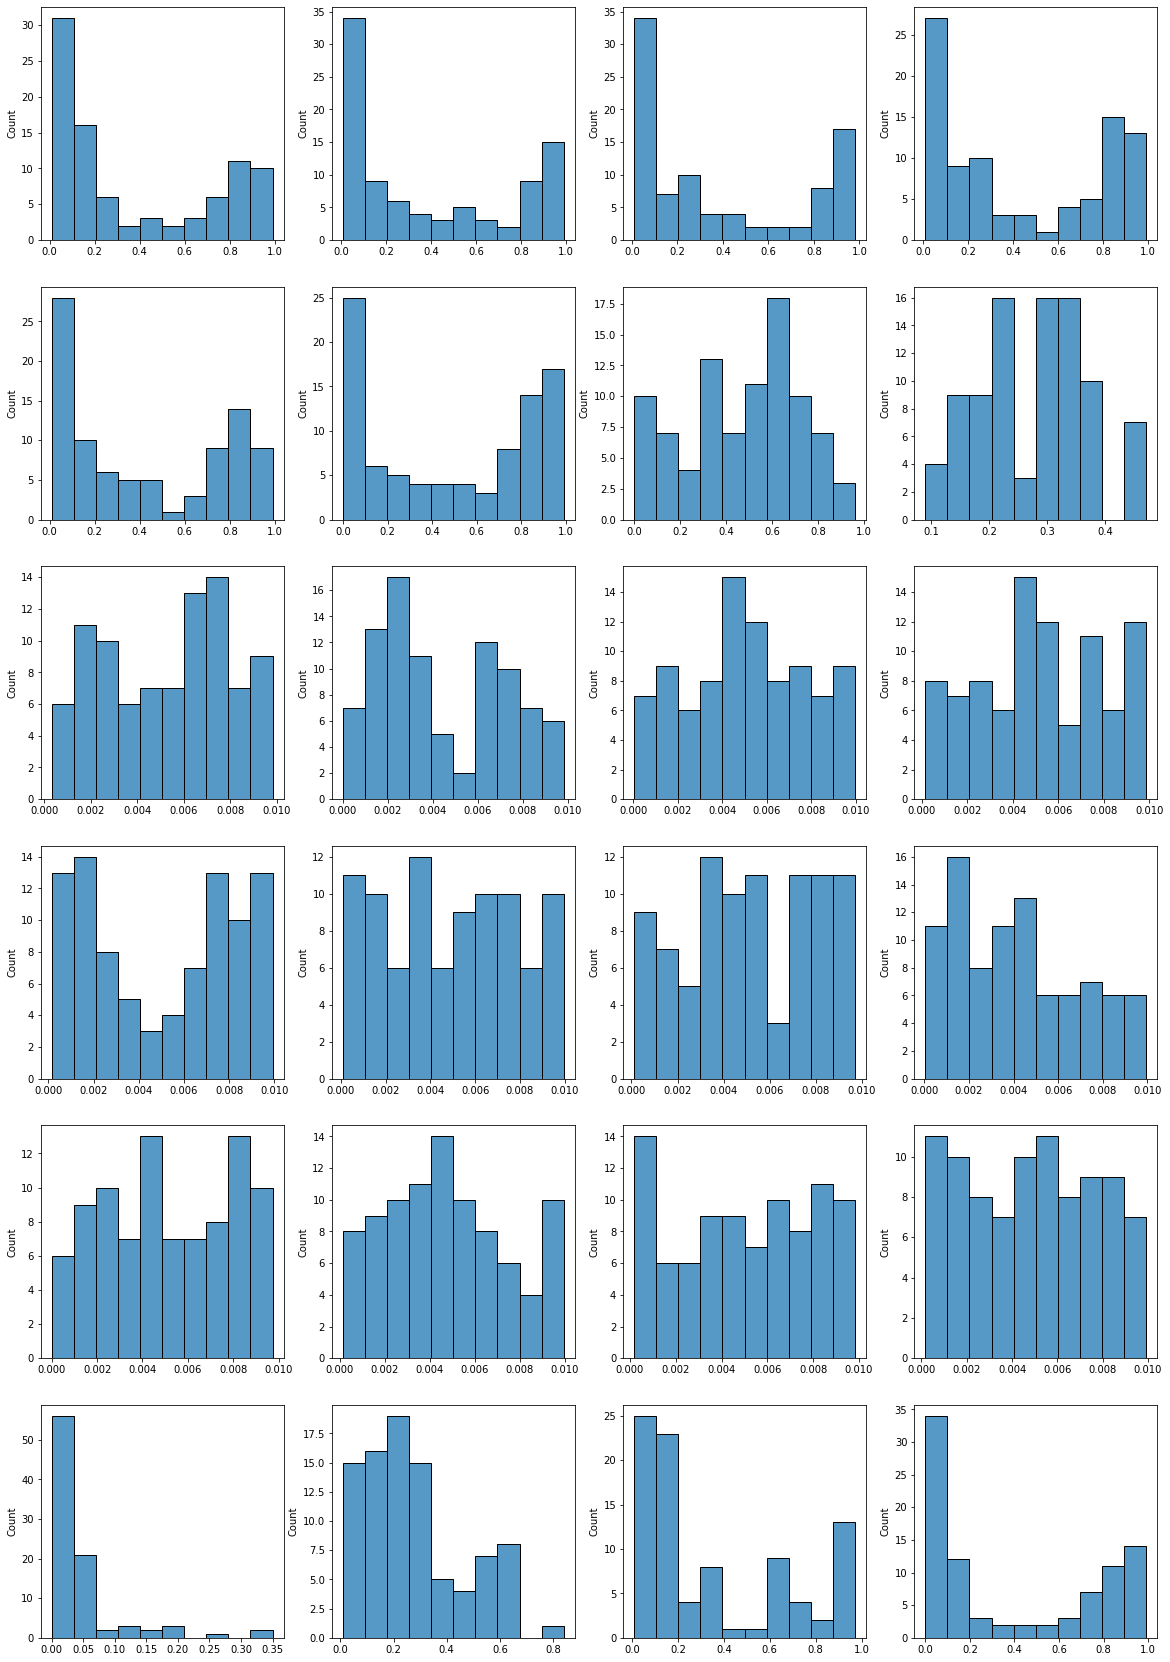

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))

for hour in range(24):
    sns.histplot(data=np.array(pits[hour]), bins=10, ax=axs[hour // 4][hour % 4])